In [1]:
!pip install ../input/sartorius-dataset/detectron/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/sartorius-dataset/detectron/whls 
!pip install ../input/sartorius-dataset/detectron/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/sartorius-dataset/detectron/whls 
!pip install ../input/sartorius-dataset/detectron/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/sartorius-dataset/detectron/whls 
!pip install ../input/sartorius-dataset/detectron/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/sartorius-dataset/detectron/whls 

Looking in links: ../input/sartorius-dataset/detectron/whls
Processing /kaggle/input/sartorius-dataset/detectron/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272235 sha256=4ac0d3f61064c6ba81dba6c6438452084c0cf8ce70de37590f837a8f112ef0ff
  Stored in directory: /root/.cache/pip/wheels/8b/74/f9/fa535b4b7537ad27783c3eb7d3612a7929a6e2fb0fd16a2f59
Successfully built pycocotools
Looking in links: ../input/sartorius-dataset/detectron/whls
Processing /kaggle/input/sartorius-dataset/detectron/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at ht

In [2]:
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *

In [3]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')

In [4]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [5]:
ids, masks=[],[]
test_names = (dataDir/'test').ls()

Initiate a Predictor from our trained model

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = os.path.join('../input/sartorius-dataset', 'model_best _final.pth')  
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


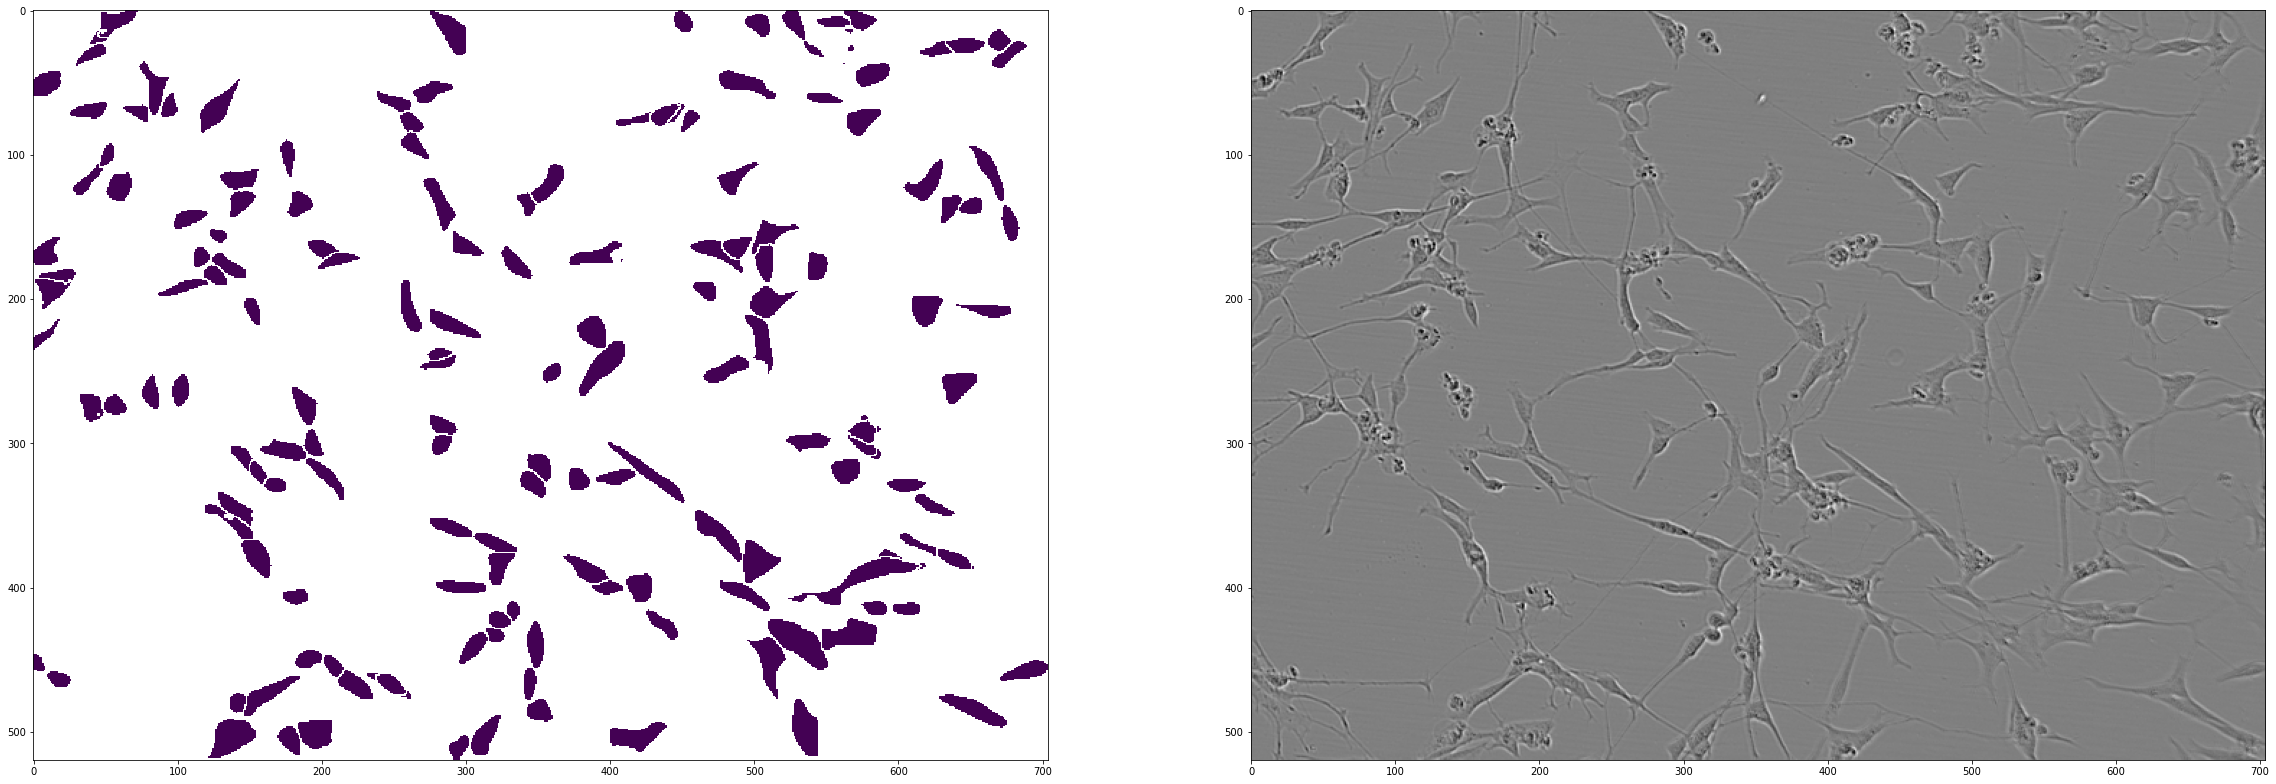

In [7]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

In [8]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [9]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,235265 5 235969 7 236673 9 237377 11 238081 12...
1,7ae19de7bc2a,183924 5 184628 7 185332 8 186036 9 186740 10 ...
2,7ae19de7bc2a,177491 2 178194 4 178897 5 179600 6 180303 7 1...
3,7ae19de7bc2a,139301 1 140003 19 140706 22 141410 23 142114 ...
4,7ae19de7bc2a,74419 5 75120 9 75822 11 76524 12 77226 12 779...
